# Проект e-commerce. Вариант 1

### Продакт-менеджер попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

**1.** Сколько у нас пользователей, которые совершили покупку только один раз?

**2.** Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

**3.** По каждому товару определить, в какой день недели товар чаще всего покупается.

**4.** Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

**5.** Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

**6.** Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

In [1]:
#Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import datetime

In [2]:
# Загружаем данные
list_customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig')
list_orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg')
list_order_items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw')

In [7]:
# В некоторых колонках меняем тип данных на datetime
column_list = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", 
                "order_delivered_customer_date", "order_estimated_delivery_date"]
list_orders[column_list] = list_orders[column_list].apply(pd.to_datetime)

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [8]:
# Отбираем покупателей, имеющих только 1 позаказный идентификатор пользователя(т.е. совершивших одно действие в нашей системе)
one_order = list_customers.groupby('customer_unique_id', as_index=False).agg({'customer_id':'count'}).query("customer_id == 1") 

In [9]:
# Объединяем таблицы
one_order = one_order.drop(columns='customer_id')
list_customer_and_orders = one_order.merge(list_customers, on='customer_unique_id').merge(list_orders, on='customer_id')

In [10]:
# Отбираем заказы со статусами 'shipped'(отгружен со склада) и 'delivered'(доставлен пользователю), 
# т.к. заказы с данными статусами можно считать совершенной покупкой
purchases = list_customer_and_orders.query("order_status == 'delivered' or order_status == 'shipped'")
purchases.head()

,customer_unique_id,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,2017-10-12 20:29:41,2017-10-12 20:49:17,2017-10-13 20:08:19,2017-11-01 21:23:05,2017-11-13
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,2017-11-14 19:45:42,2017-11-14 20:06:52,2017-11-16 19:52:10,2017-11-27 23:08:56,2017-12-05


In [11]:
print(purchases.shape[0], 'пользователей совершили покупку 1 раз')

91411 пользователей совершили покупку 1 раз


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [12]:
# В процессе изучения данных было обнаружено несколько "странных" заказов у которых есть данные о времени доставки, 
# но значится статус "canceled"(отменен). Возможно, покупатели отказались от заказа при получении, 
# или же это просто ошибка в данных
list_orders.query("order_status != 'delivered' and order_delivered_customer_date.isna() == False") 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [13]:
# Также были обнаружены заказы со статусом "delivered"(доставлен пользователю), но с отсутствующей датой доставки
list_orders.query("order_status == 'delivered' and order_delivered_customer_date.isna() == True")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [14]:
# Отбираем заказы с отсутствующей датой доставки пользователю и статусами != 'delivered'.
# Такие фильтры выбраны для исключения обнаруженных ранее "странных" заказов.
undelivered_orders = list_orders.query("order_delivered_customer_date.isna() == True and order_status != 'delivered'")
undelivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [15]:
# Создаем колонку с месяцем доставки
undelivered_orders['month'] = undelivered_orders.order_estimated_delivery_date.dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Группируем данные по месяцу и статусу заказа, считаем количество заказов и создаем сводную таблицу
reasons_for_non_delivery = undelivered_orders.groupby(['month','order_status'], as_index=False).agg({'order_id':'count'}).pivot(index='month', columns='order_status', values='order_id').reset_index().fillna(0)
reasons_for_non_delivery

order_status,month,approved,canceled,created,invoiced,processing,shipped,unavailable
0,2016-09,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2016-10,0.0,3.0,0.0,0.0,0.0,1.0,0.0
2,2016-11,0.0,10.0,0.0,9.0,0.0,1.0,5.0
3,2016-12,0.0,7.0,0.0,9.0,2.0,7.0,2.0
4,2017-02,0.0,2.0,0.0,1.0,1.0,6.0,2.0
5,2017-03,1.0,26.0,0.0,21.0,38.0,41.0,66.0
6,2017-04,0.0,22.0,0.0,5.0,23.0,35.0,19.0
7,2017-05,1.0,23.0,0.0,19.0,12.0,60.0,16.0
8,2017-06,0.0,29.0,0.0,11.0,22.0,52.0,29.0
9,2017-07,0.0,21.0,0.0,10.0,13.0,51.0,34.0


In [17]:
# Выводим среднее количество заказов в месяц по причинам. 
# Причины недоставки заказа:
# - approved - подтвержден, но не был выставлен счет на оплату;
# - canceled - заказ был отменен;
# - created - заказ был создан, но не подтвержден, возможно товара не оказалось на складе;
# - invoiced - был выставлен счет, но заказ так и не был оплачен;
# - processing - возникли проблемы на этапе сборки;
# - shipped - возникли проблемы во время доставки, например заказ был потерян логистической службой;
# - unavailable - недоступен.
reasons_for_non_delivery.mean().round(2)

order_status
approved        0.08
canceled       23.81
created         0.19
invoiced       12.08
processing     11.58
shipped        42.58
unavailable    23.42
dtype: float64

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается

In [23]:
# Отбираем заказы с подтверженной оплатой
orders = list_order_items.merge(list_orders, on='order_id')
orders = orders.query("order_approved_at.isna() == False")

In [24]:
# Создаем датасет с необходимыми колонками
product_by_day_of_week = orders[['product_id', 'order_approved_at']]
product_by_day_of_week

,product_id,order_approved_at
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:10:18
4,ac6c3623068f30de03045865e4e10089,2017-02-04 14:10:13
...,...,...
112645,4aa6014eceb682077f9dc4bffebc05b0,2018-04-25 04:11:01
112646,32e07fd915822b0765e448c4dd74c828,2018-07-17 04:31:48
112647,72a30483855e2eafc67aee5dc2560482,2017-10-24 17:14:25
112648,9c422a519119dcad7575db5af1ba540e,2017-08-15 00:04:32


In [25]:
# Создаем колонку с наименованием дня покупки
product_by_day_of_week['day_of_week'] = product_by_day_of_week.order_approved_at.dt.strftime('%A')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# Группируем товары по дню покупки и считаем количество 
product_by_day_of_week = product_by_day_of_week.groupby(['product_id', 'day_of_week'], as_index=False).agg({'order_approved_at':'count'}).rename(columns={'order_approved_at':'number_of_order'}) 
product_by_day_of_week.head()

,product_id,day_of_week,number_of_order
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [27]:
# По каждому товару выводим день недели в который он чаще всего покупается
product_by_day_of_week.groupby(by=['product_id']).max()

,day_of_week,number_of_order
product_id,,
00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
00088930e925c41fd95ebfe695fd2655,Tuesday,1
0009406fd7479715e4bef61dd91f2462,Friday,1
000b8f95fcb9e0096488278317764d19,Wednesday,1
000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...
fff6177642830a9a94a0f2cba5e476d1,Saturday,1
fff81cc3158d2725c0655ab9ba0f712c,Monday,1
fff9553ac224cec9d15d49f5a263411f,Saturday,1


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [28]:
# Объединяем таблицы, выбираем заказы с подтвержденной оплатой (т.к. это можно считать совершенной покупкой), 
# отбираем необходимые колонки с данными
df_orders = list_customers.merge(list_orders, on='customer_id')
df_orders = df_orders.query("order_approved_at.isna() == False")
df_orders = df_orders[['customer_unique_id', 'order_id', 'order_approved_at']]

In [29]:
# Создаем колонку с месяцем покупки и колонку с количеством недель в каждом месяце
df_orders['month_of_purchase'] = df_orders.order_approved_at.dt.to_period('M')
df_orders['number_of_week'] = (df_orders.month_of_purchase.dt.days_in_month / 7).round(2)

In [30]:
# Считаем количество заказов по месяцам
orders_per_month = df_orders.groupby(['customer_unique_id', 'month_of_purchase', 'number_of_week'], as_index=False) \
                            .agg({'order_id':'count'})
orders_per_month.head(3)

,customer_unique_id,month_of_purchase,number_of_week,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.43,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.43,1


In [31]:
# Создаем колонку и считаем среднее количество покупок в месяц
orders_per_month['mean_per_week'] = (orders_per_month.order_id/orders_per_month.number_of_week).round(2)

In [32]:
# Создаем сводную таблицу с данными о среднем количестве покупок в неделю каждого пользователя по месяцам
orders_per_month.pivot(index='customer_unique_id', columns='month_of_purchase', values='mean_per_week').reset_index().fillna(0)

month_of_purchase,customer_unique_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.23,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.23,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
95993,fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.23,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
95994,ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
95995,ffff5962728ec6157033ef9805bacc48,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.23,0.0,0.0,0.0,0.0


### 5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

In [33]:
# Объединяем таблицы, отбираем необходимые колонки и фильтруем данные (берем данные с января 2017 по декабрь 2017)
df = list_customers.merge(list_orders, on='customer_id')
df = df[['customer_unique_id', 'order_id', 'order_approved_at']].query("order_approved_at > '2016-12-31' and order_approved_at < '2018-01-01'")
df.head()

,customer_unique_id,order_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41
10,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20
12,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17


In [34]:
# Проверяем, нет ли пропущенных значений в данных
df.isna().sum()

customer_unique_id    0
order_id              0
order_approved_at     0
dtype: int64

In [35]:
# Считаем какой % пользователей совершили повторную покупку
n_orders = df.groupby(['customer_unique_id'])['order_id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer_unique_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% покупателей совершили покупку более одного раза.')

2.85% покупателей совершили покупку более одного раза.


In [36]:
# Cоздаем переменные cohort(месячная когорта на основе даты первой покупки) и order_month(усеченный месяц даты покупки)
df['order_month'] = df['order_approved_at'].dt.to_period('M')
df['cohort'] = df.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M') 

In [37]:
# Агрегируем данные по когорте и order_month и подсчитываем количество уникальных клиентов в каждой группе. 
# Дополнительно добавляем 'period_number', которое указывает количество периодов между месяцем когорты и месяцем покупки.
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [38]:
# Создаем сводную таблицу df_cohort, в которой каждая строка содержит информацию о данной когорте, 
# а каждый столбец содержит значения за определенный период.
cohort_pivot = df_cohort.pivot_table(index = 'cohort', columns = 'period_number', values = 'n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,727.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,2.0,2.0
2017-02,1736.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,NaN
2017-03,2643.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04,2324.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05,3592.0,19.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN,NaN
2017-06,3148.0,15.0,11.0,13.0,8.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3844.0,20.0,13.0,8.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4204.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4149.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Для получения матрицы удержания, делим значения каждой строки на первое значение строки, которое является размером когорты
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.005502,0.002751,0.001376,0.004127,0.001376,0.005502,0.001376,0.001376,NaN,0.002751,0.002751
2017-02,1.0,0.002304,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152,NaN
2017-03,1.0,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,NaN,NaN
2017-04,1.0,0.006024,0.002151,0.001721,0.003012,0.002582,0.003442,0.002582,0.003442,NaN,NaN,NaN
2017-05,1.0,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,NaN,NaN,NaN,NaN
2017-06,1.0,0.004765,0.003494,0.004130,0.002541,0.003494,0.003812,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005203,0.003382,0.002081,0.003382,0.001821,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006660,0.003568,0.002617,0.003806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006508,0.004820,0.003374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


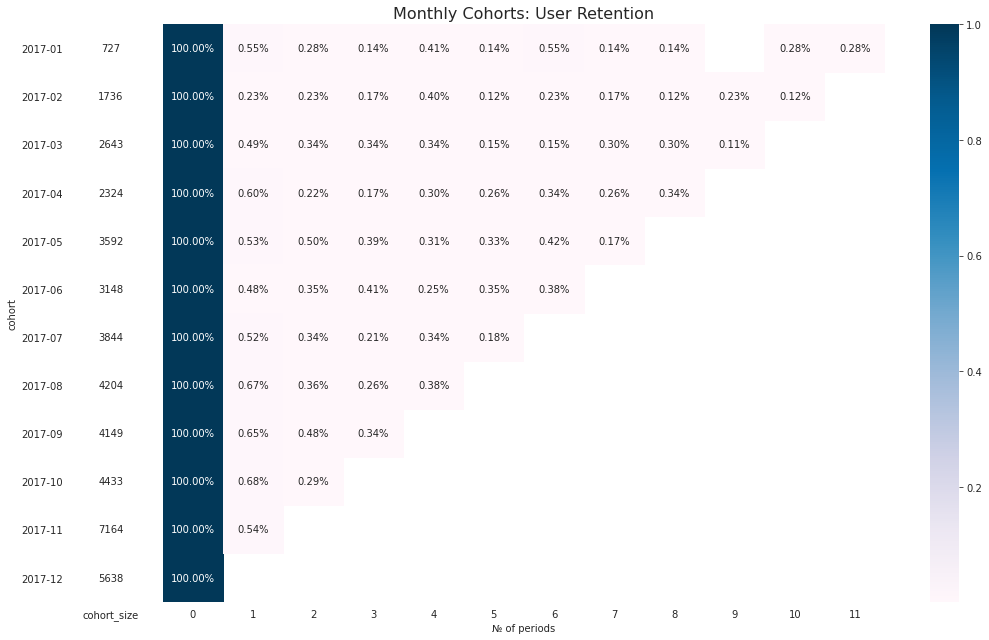

In [40]:
# Создаем тепловую карту
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 9), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='0.2%', 
                cmap='PuBu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='№ of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Самый высокий retention rate на 3-ий месяц выявлен в когорте '2017-05'

In [41]:
# На основе предыдущих действий пишем функцию для проведения когортного анализа
def cohort_analysys(customer_unique_id, order_id, order_approved_at):
    df['order_month'] = df['order_approved_at'].dt.to_period('M')
    df['cohort'] = df.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M') 
    df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
    
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(15, 9), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='0.2%', 
                cmap='PuBu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='№ of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

None


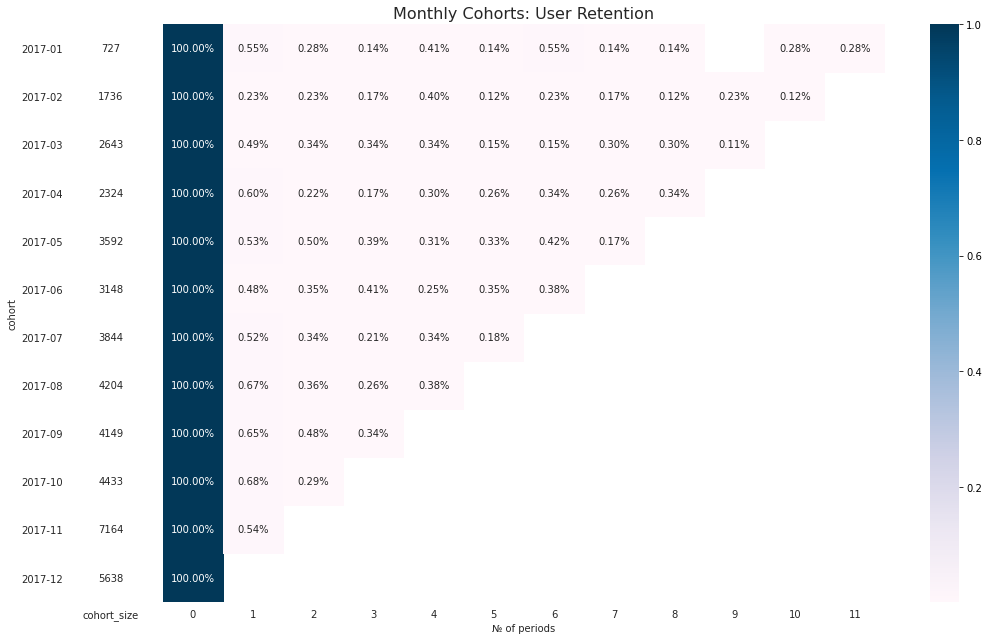

In [42]:
# Вызываем функцию cohort_analysys
print(cohort_analysys(df.customer_unique_id, df.order_id, df.order_approved_at))

### 6. Построй RFM-кластеры для пользователей. Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).

In [43]:
# Объединяем таблицы и отбираем необходимые колонки
all_data = list_customers.merge(list_orders, on='customer_id').merge(list_order_items, on='order_id').query("order_approved_at.isna()==False")
all_data = all_data[['customer_unique_id', 'order_id', 'order_approved_at', 'order_estimated_delivery_date', 'price']]
all_data.head(3)

,customer_unique_id,order_id,order_approved_at,order_estimated_delivery_date,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,2017-06-05,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,2018-02-06,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,2018-06-13,139.94


In [44]:
# Создаем переменную last_date, используем ее в качестве текущей даты, для расчета Recency(разницы между текущей датой и 
# датой последнего платежа). Исходя из того, что мы используем устаревшие данные, для расчетов была выбрана максимальная 
# дата из колонки 'order_estimated_delivery_date'(обещанная дата доставки)
last_date = all_data['order_estimated_delivery_date'].max()

In [45]:
# Формируем таблицу с метриками recency(разница между текущей датой и датой последнего платежа), 
# frequency(количество покупок) и monetary_value(сумма покупок) для каждого пользователя
rfmTable = all_data.reset_index().groupby('customer_unique_id').agg({'order_approved_at': lambda x: (last_date - x.max()).days, 'order_id': 'count', 'price': 'sum'})
rfmTable.rename(columns={'order_approved_at': 'recency', 'order_id': 'frequency', 'price': 'monetary_value'}, inplace=True)
rfmTable.head(5)

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,167,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,170,1,18.90
0000f46a3911fa3c0805444483337064,593,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,377,1,25.99
0004aac84e0df4da2b147fca70cf8255,344,1,180.00


In [46]:
# Считаем описательные статистики
rfmTable.describe()

,recency,frequency,monetary_value
count,95407.000000,95407.000000,95407.000000
mean,293.942499,1.180574,142.442098
std,153.124543,0.621478,217.667272
min,51.000000,1.000000,0.850000
25%,170.000000,1.000000,47.900000
50%,274.000000,1.000000,89.900000
75%,403.000000,1.000000,155.000000
max,769.000000,24.000000,13440.000000


In [47]:
# Функция для оценки показателя recency
def recency_score(x):
    if x > 180:        # Покупали более 180 дней назад
        return 1
    if 90 < x < 180:   # Покупали в период от 90 до 180 дней назад
        return 2
    else:
        return 3       # Покупали менее 90 дней назад

In [48]:
# Функция для оценки показателя frequency
# (критерий для оценки был выбран исходя из максимального и среднего значения этого показателя)
def frequency_score(x):
    if x > 20:        # Совершили более 20 покупок
        return 3
    if 10 < x < 20:   # Совершили от 10 до 20 покупок
        return 2
    else:
        return 1     # Совершили менее 10 покупок

In [49]:
# Функция для оценки показателя monetary_value
# (критерий для оценки был выбран исходя из максимального и среднего значения этого показателя)
def monetary_value_score(x):
    if x > 200:        # Совершили покупок на сумму более 200
        return 3
    if 100 < x < 200:  # Совершили покупок на сумму от 100 до 200
        return 2
    else:              # Совершили покупок на сумму менее 100
        return 1

In [50]:
# Строим таблицу с разделением на кластеры, каждому кластеру присвоены 3 показателя:
# r_score(давность), f_score(частота), m_score(сумма).
segmented_rfm = rfmTable
segmented_rfm['r_score'] = segmented_rfm['recency'].apply(recency_score)
segmented_rfm['f_score'] = segmented_rfm['frequency'].apply(frequency_score)
segmented_rfm['m_score'] = segmented_rfm['monetary_value'].apply(monetary_value_score)
segmented_rfm['RFMScore'] = segmented_rfm.r_score.map(str) + segmented_rfm.f_score.map(str) + segmented_rfm.m_score.map(str)
segmented_rfm

,recency,frequency,monetary_value,r_score,f_score,m_score,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,167,1,129.90,2,1,2,212
0000b849f77a49e4a4ce2b2a4ca5be3f,170,1,18.90,2,1,1,211
0000f46a3911fa3c0805444483337064,593,1,69.00,1,1,1,111
0000f6ccb0745a6a4b88665a16c9f078,377,1,25.99,1,1,1,111
0004aac84e0df4da2b147fca70cf8255,344,1,180.00,1,1,2,112
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,503,2,1570.00,1,1,3,113
fffea47cd6d3cc0a88bd621562a9d061,318,1,64.89,1,1,1,111
ffff371b4d645b6ecea244b27531430a,624,1,89.90,1,1,1,111


In [51]:
# Таблица средних значений метрик R, F, M для каждого кластера
segmented_rfm.groupby('RFMScore', as_index=False).agg({'recency':'mean', 'frequency':'mean', 'monetary_value':'mean'})

,RFMScore,recency,frequency,monetary_value
0,111,362.860638,1.084827,53.900664
1,112,354.035335,1.219222,144.421285
2,113,363.322474,1.422528,447.273641
3,122,639.000000,11.000000,108.900000
4,123,278.526316,12.736842,883.703158
5,131,464.000000,21.000000,31.800000
6,211,136.421978,1.088212,53.725111
7,212,137.149011,1.202271,143.081621
8,213,136.541427,1.512682,473.601975
9,221,138.000000,12.000000,61.260000


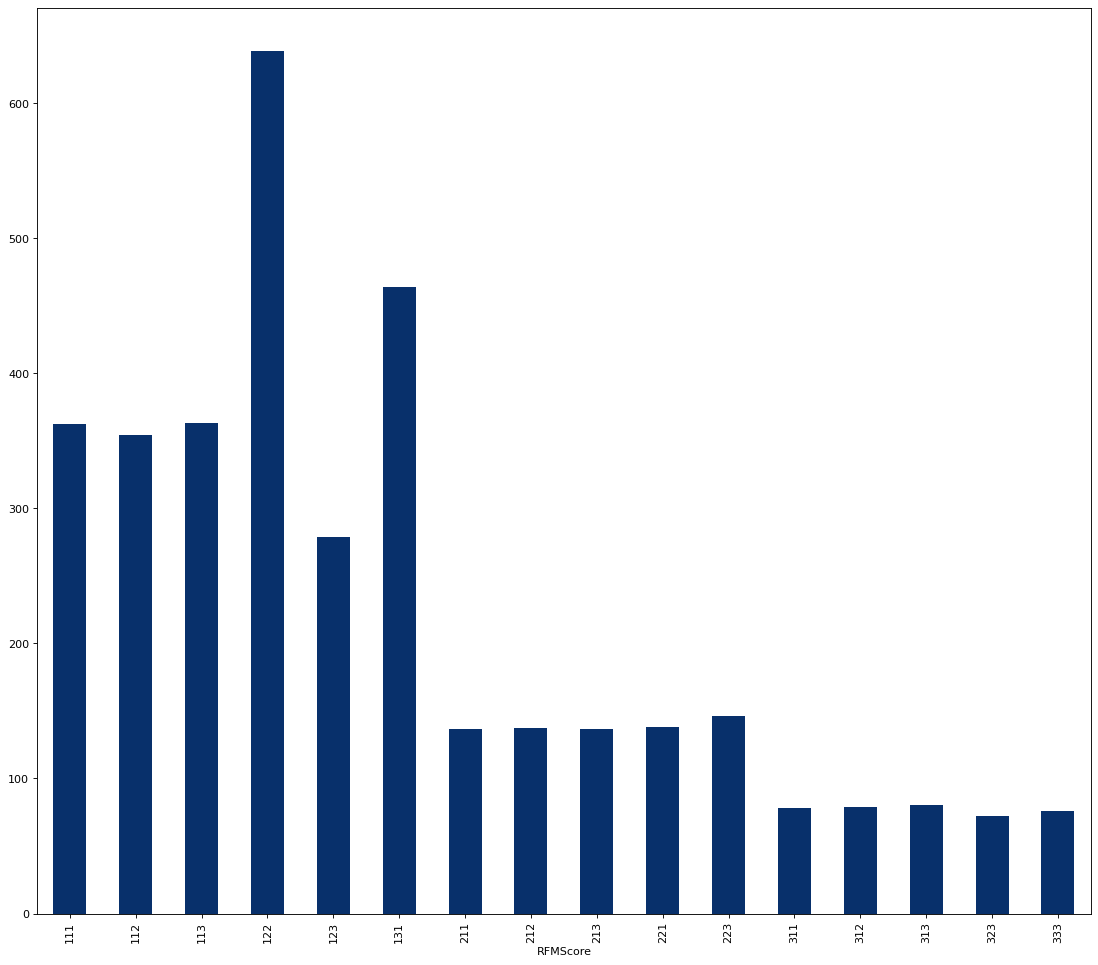

In [52]:
# График распределения среднего значения показателя recency по кластерам
fig=plt.figure(figsize=(17, 15), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

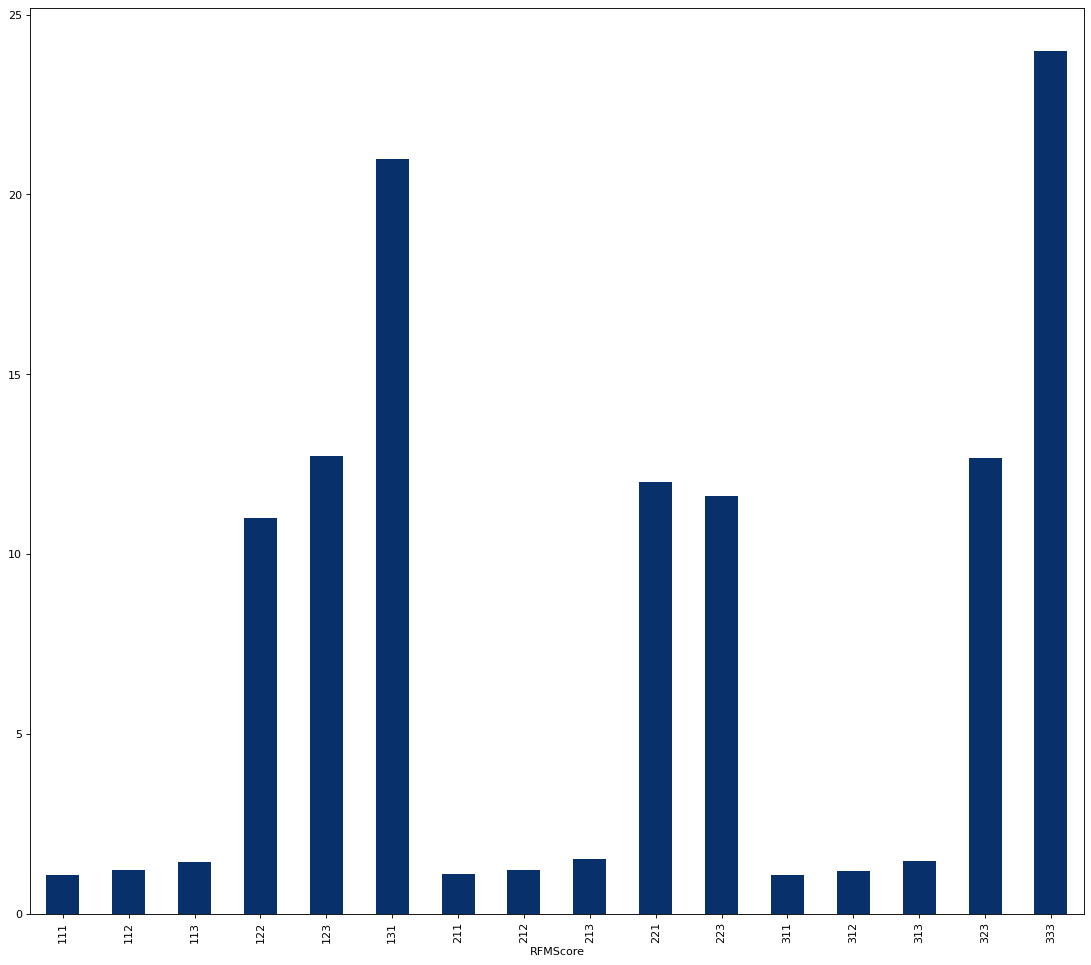

In [53]:
# График распределения среднего значения показателя frequency по кластерам
fig=plt.figure(figsize=(17, 15), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

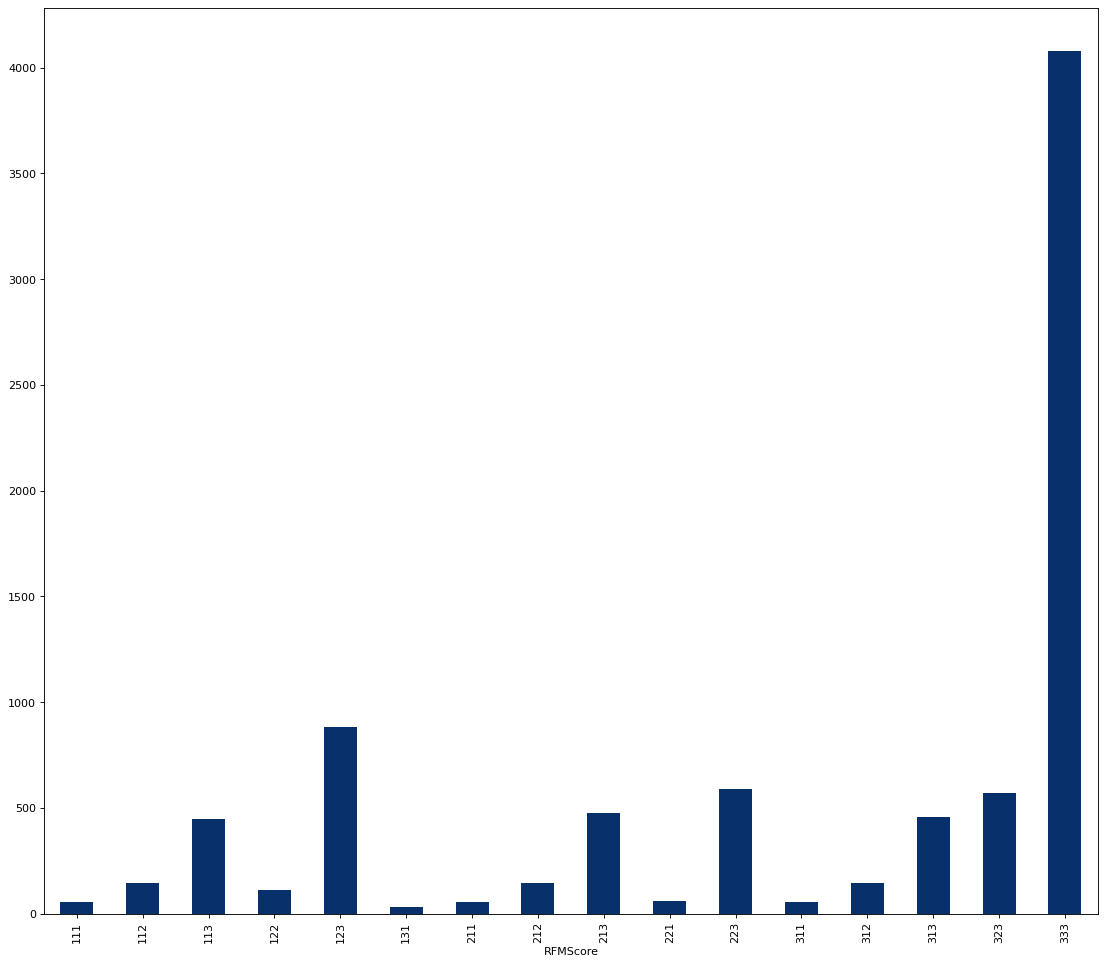

In [58]:
# График распределения среднего значения показателя monetary_value по кластерам
fig=plt.figure(figsize=(17, 15), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')
plt.show()